Consider a cylindrical tank with no outlet flow and an adjustable inlet flow that is controlled by a valve. The inlet flow rate is not measured but there is a level measurement that shows how much fluid has been added to the tank. The objective of this exercise is to develop a controller that can maintain a certain water level by automatically adjusting the inlet flow rate.



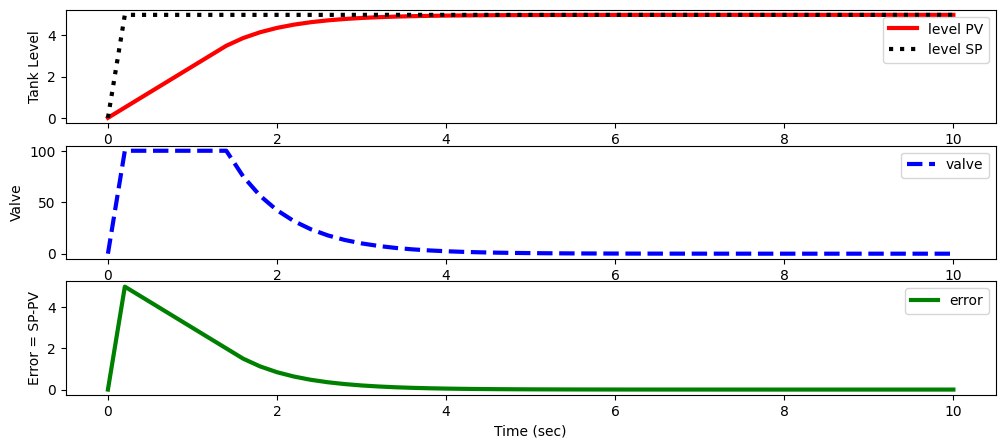

In [62]:
from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import datetime

# animate plots?
animate=True # True / False

# define tank model
def tank(Level,time,c,valve):
    rho = 1000.0 # water density (kg/m^3)
    A = 1.0      # tank area (m^2)
    # calculate derivative of the Level
    dLevel_dt = (c/(rho*A)) * valve
    return dLevel_dt

# time span for the simulation for 10 sec, every 0.1 sec
steps = 51
duration = 10
ts = np.linspace(0,duration,steps)

span = datetime.timedelta(seconds=duration)
step_dx = span / (steps - 1)
zero_time = datetime.datetime(1, 1, 1, 0, 0, 0)


# valve operation
c = 50.0          # valve coefficient (kg/s / %open)
u = np.zeros(101) # u = valve % open

# level initial condition
Level0 = 0

# initial valve position
valve = 0
valve_hist = []


# for storing the results
z = np.zeros(101)
es = np.zeros(101)
sps = np.zeros(101)


ubias = 0
Kc = 50.0

# TO DO: record the desired level (set point)
SP = 5

plt.figure(1,figsize=(12,5))
if animate:
    plt.ion()
    plt.show()

y_hist = []
time = [zero_time.time()]
time_temp = [zero_time]

# simulate with ODEINT
for i in range(steps):
    # calculate the error
    error = SP - Level0

    valve = ubias + Kc * error
    valve = max(0,valve)
    valve = min(100,float(valve))
    valve_hist.append(valve)

    u[i+1] = valve   # store the valve position
    es[i+1] = error  # store the error 
    y = odeint(tank,Level0,[0,0.1],args=(c,valve))
    y_hist.append(y[1][0])
    Level0 = y[-1] # take the last point
    z[i+1] = Level0 # store the level for plotting
    sps[i+1] = SP

    # time
    if (i < steps - 1):
        current_time = time_temp[i]
        time_temp.append(current_time + step_dx)
        time.append((current_time + step_dx).time())


    if animate:
    # update plot
        display.clear_output(wait=True)
        plt.figure(1,figsize=(12,5))
        plt.subplot(3,1,1)
        plt.plot(ts[0:i+1],z[0:i+1],'r-',linewidth=3,label='level PV')
        plt.plot(ts[0:i+1],sps[0:i+1],'k:',linewidth=3,label='level SP')
        plt.ylabel('Tank Level')
        plt.legend(loc='best')
        plt.subplot(3,1,2)
        plt.plot(ts[0:i+1],u[0:i+1],'b--',linewidth=3,label='valve')
        plt.ylabel('Valve')    
        plt.legend(loc='best')
        plt.subplot(3,1,3)
        plt.plot(ts[0:i+1],es[0:i+1],'g-',linewidth=3,label='error')
        plt.ylabel('Error = SP-PV')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.pause(0.1)

if not animate:
    # plot results
    plt.subplot(3,1,1)
    plt.plot(ts,z,'r-',linewidth=3,label='level PV')
    plt.plot(ts,sps,'k:',linewidth=3,label='level SP')
    plt.ylabel('Tank Level')
    plt.legend(loc='best')
    plt.subplot(3,1,2)
    plt.plot(ts,u,'b--',linewidth=3,label='valve')
    plt.ylabel('Valve')    
    plt.legend(loc='best')
    plt.subplot(3,1,3)
    plt.plot(ts,es,'g-',linewidth=3,label='error')
    plt.ylabel('Error = SP-PV')    
    plt.xlabel('Time (sec)')
    plt.legend(loc='best')
    plt.show()

data = {'Time': time,
        'Level': y_hist,
        'Valve Opening': valve_hist}

# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('tank_levels.csv', index=False)
